## CSCI 6380 Mini Project

Chest X-Ray Images (Pneumonia) dataset from Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

The zipfile downloaded from the link above is extracted to a local folder named `chest_xray`. The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

- Data: https://data.mendeley.com/datasets/rscbjbr9sj/2
- License: CC BY 4.0
- Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

### TODO

- [X] Data input and simple EDA.
- [X] Have a baseline model.
- [ ] Generate a random split using just the training set, and see the performance on the "test set". If it's much better, then maybe there's mislabeling in the given test set.
- [ ] Use a weighted cross entropy loss function to account for the class imbalance.
- [ ] [Augment](https://stackoverflow.com/questions/51677788/data-augmentation-in-pytorch)/Resample the training set to balance the normal and pneumonia samples.
- [ ] Tune the hyperparameters.
- [ ] Log images with wrong predictions into TensorBoard and visualize them. Possibly [useful link](https://www.tensorflow.org/tensorboard/image_summaries) from TensorBoard.

In [23]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from core.data import PneumoniaDataModule
from core.model import PneumoniaDetector
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from torch.nn import functional as F

### Exploratory Data Analysis

Machine learning aside, we first need to check the number of samples under each data category (normal vs. pneumonia). As described above, we simply need to walk the subdirectories and count the number of files.

In [3]:
data_dir = Path("./chest_xray").expanduser().absolute()
labels = ["NORMAL", "PNEUMONIA"]

# Check number of images in each category
label_counts = {}
for data_type in ("train", "val", "test"):
    label_counts[data_type] = {}
    for label in labels:
        label_count = len([x for x in (data_dir / data_type / label).glob("*.jpeg")])
        label_counts[data_type][label] = label_count

label_counts = pd.DataFrame(label_counts).T
label_counts["normal_freq"] = label_counts["NORMAL"] / (
    label_counts["NORMAL"] + label_counts["PNEUMONIA"]
)
label_counts

,NORMAL,PNEUMONIA,normal_freq
train,1341,3875,0.257094
val,8,8,0.500000
test,234,390,0.375000


dm_test.pneumonia_test[:4]The test set is roughly 10% of the entire dataset. Two obvious problems can be found from this table:

1. The validation set is too small, and
2. There's almost three times as many pneumonia samples as normal ones.

The test set should be left aside and only used to assess the performance of the final model. Ignoring the class imbalance problem for now, we can first read in all the training and validation samples, and use a random 90-10 split to generate new training and validation sets. Since we're planning to use [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) for this project, we might as well start from the beginning and wrap the data loading code in a [datamodule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html). The core methods of a `datamodule` are:

1. `prepare_data` downloads data (i.e. writes to disk). In a distributed setting this method is only called from a single process. In our case we skip the definition of this method because the data was already downloaded.
2. `setup` contains data operations we might want to perform on every GPU, e.g. apply transforms, perform train/val splits, count frequency of the labels, etc.
3. `(train|val|test)_dataloader` generates data loaders for the corresponding datasets. Usually most of the work is already done in `setup`, so we just need to wrap the dataset and return a `DataLoader`. The batch sizes and number of threads to read the data are defined here.

The defined `datamodule` can be found in `./core/data.py`. By default the files are not sorted, so all the normal samples would be retrieved first and then we get all the pneumonia samples. We can grab some images and see if there's any obvious differences between the groups.

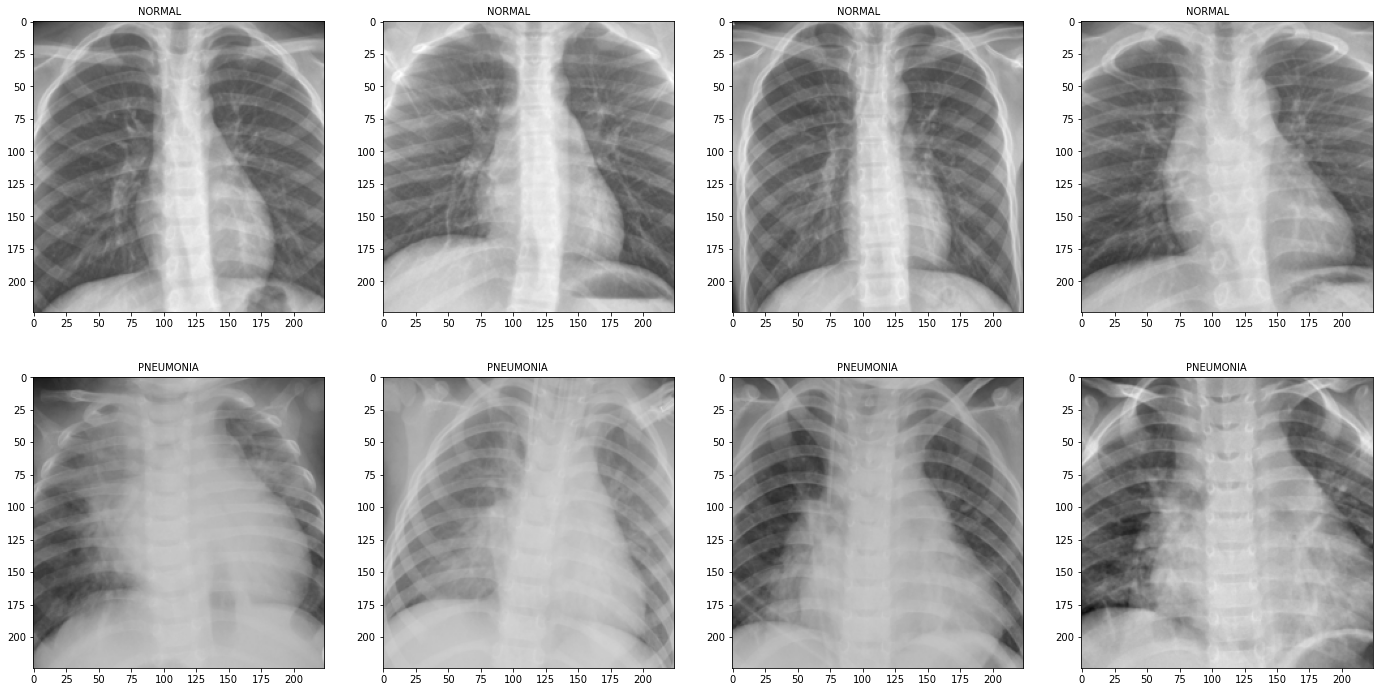

In [4]:
dm_test = PneumoniaDataModule(data_dir, batch_size=4)
dm_test.setup("test")

normal_batch = [dm_test.pneumonia_test[i] for i in range(4)]
normal_labels = [normal_batch[i][1] for i in range(4)]
normal_imgs = [normal_batch[i][0] for i in range(4)]

pneumonia_batch = [dm_test.pneumonia_test[i] for i in range(-4, 0)]
pneumonia_labels = [pneumonia_batch[i][1] for i in range(4)]
pneumonia_imgs = [pneumonia_batch[i][0] for i in range(4)]

imgs = normal_imgs + pneumonia_imgs
img_labels = normal_labels + pneumonia_labels
label_idx = {val: key for key, val in dm_test.class_to_idx.items()}

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))
for i in range(8):
    axs[i // 4, i % 4].imshow(imgs[i].permute(1, 2, 0))
    axs[i // 4, i % 4].text(80, -5, label_idx[img_labels[i]])

[Here's a pretty good explanation](https://radiologyassistant.nl/chest/chest-x-ray/lung-disease) of what we should be looking for in the chest X-rays. From what I can tell, the images of patients with pneumonia are more cloudy, and the edges of the lung aren't as clear as the ones in the normal images.

### Data-Independent Model

We may calculate the metrics of a "model" that always predicts the most common class (which is pneumonia in this case) or a model that gives random guesses. These metrics can be used as a baseline for all future models.

In [37]:
pneumonia_sample_size = label_counts.loc["train", "PNEUMONIA"]
normal_sample_size = label_counts.loc["train", "NORMAL"]
fake_train = [1] * pneumonia_sample_size + [0] * normal_sample_size
common_pred = [1] * (pneumonia_sample_size + normal_sample_size)
random_pred = np.random.default_rng(42).choice(
    2, (pneumonia_sample_size + normal_sample_size)
)

baseline_metrics = pd.DataFrame(
    [
        (
            accuracy_score(fake_train, common_pred),
            precision_score(fake_train, common_pred),
            recall_score(fake_train, common_pred),
            f1_score(fake_train, common_pred),
        ),
        (
            accuracy_score(fake_train, random_pred),
            precision_score(fake_train, random_pred),
            recall_score(fake_train, random_pred),
            f1_score(fake_train, random_pred),
        ),
    ],
    columns=["Accuracy", "Precision", "Recall", "F1"],
    index=["common_class", "random_guess"]
)
baseline_metrics

,Accuracy,Precision,Recall,F1
common_class,0.742906,0.742906,1.000000,0.852491
random_guess,0.500383,0.745835,0.496774,0.596344


### Baseline Model

The PyTorch library has some pretrained models availabe in the [torchvision](https://pytorch.org/vision/0.8/models.html) package. Here's an article [comparing some of those architectures](https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96), and we'll be using [ResNet18](https://arxiv.org/abs/1512.03385) as the backbone of our feature extractor.

Similar to the `LightningDataModule`, in PyTorch Lightning we define a model using `LightningModule`. It organizes our PyTorch code into the following sections:

1. `__init__` is the model/system definition.
2. `forward` for making inference and predictions.
3. `training_step` is the training loop. Stuff like calculating the loss function and model metrics go here. We can also define `training_step_end` and `training_epoch_end` hooks for more fine-grained control.
4. `(validation|test)_step` are not required and are very similar to `training_step`. We're defining these as well because we have some custom metrics that we want to log.
5. `configure_optimizers` as its name suggests, configures one or multiple optimizers.

We'll try to follow [PyTorch Lightning's style guides](https://pytorch-lightning.readthedocs.io/en/stable/starter/style_guide.html) when defining our model. The model can be found in `./core/model.py`. What we did was simply stripping out the last layer of ResNet, and replace it with a layer that has the same input dimensions but an output of only two nodes. The layers from ResNet are all frozen for faster training.

In [4]:
# Set random seed for pytorch, numpy, python.random
pl.seed_everything(42)

# Init data and model
dm = PneumoniaDataModule(
    data_dir,
    batch_size=64,
    num_workers=16,
)

model = PneumoniaDetector(lr=1e-3)

# setup trainer
logger = TensorBoardLogger("tb_logs", name="pneumonia_bin_classifier")
trainer = pl.Trainer(
    max_epochs=15,
    gpus=1,
    logger=logger,
    deterministic=True,
)

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [5]:
# train model
trainer.fit(model, dm)

# test on best checkpoint
test_metrics = trainer.test(datamodule=dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | backbone      | Sequential       | 11.2 M
1 | classifier    | Sequential       | 1.0 K 
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7964743375778198,
 'test_f1': 0.7964743971824646,
 'test_loss': 0.6315323710441589,
 'test_precision': 0.7573385238647461,
 'test_recall': 0.9923076629638672}
--------------------------------------------------------------------------------


The baseline model performs really well on the training and validation sets -- accuracy, precision, recall, and F1 score are all >0.95. However, the test metrics are much worse (~0.79 for all metrics except recall). We could closer examine the predictions on the test set using a confusion matrix.

In [6]:
# Evaluate on the test set: confusion matrix
model.freeze()
y_pred, y_true = [], []

for batch in dm.test_dataloader():
    x, y = batch
    y_hat = model(x.cuda())
    pred = F.log_softmax(y_hat, dim=1).argmax(dim=1)
    y_pred.append(pred)
    y_true.append(y)

y_pred = torch.cat(y_pred).cpu()
y_true = torch.cat(y_true).cpu()

mat = confusion_matrix(y_true, y_pred, labels=sorted(dm.class_to_idx.values()))
mat = pd.DataFrame(mat, columns=labels, index=labels)
mat

,NORMAL,PNEUMONIA
NORMAL,110,124
PNEUMONIA,3,387


|           | Predicted normal | Predicted Pneumonia |
|:----------|-----------------:|--------------------:|
| Normal    |              110 |                 124 |
| Pneumonia |                3 |                 387 |

From the confusion matrix, it seems we are getting a lot of false positives where normal X-rays are predicted as pneumonia images. Possible reasons are:

1. Our model is performing really well, it's just some of the images in the test set are mislabeled.
2. We're overfitting to the training set, and the false positives are because of the class imbalance.

Although (2) is the more likely reason, we could easily check (1) by holding out part of the training set as the new "test set" and train on the remaining data. If the performance on the "test set" greatly improves, then *maybe* there actually is mislabeling going on.